In [72]:
import numpy as np

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import current_weather, sky_cover, StationPlot, simple_layout, wx_code_to_numeric
from metpy.io import metar

import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [73]:
filename = "20221212_1200"
data = Dataset(filename)

In [74]:
stationName = data.variables['stationName'][:]
latitude = data.variables['latitude'][:]
longitude = data.variables['longitude'][:]
temp = data.variables['temperature'][:]
dwpt = data.variables['dewpoint'][:]
wspd = data.variables['windSpeed'][:]
wdir = data.variables['windDir'][:]
print(wdir)
gust = data.variables['windGust'][:]
weather =  data.variables['presWeather'][:]
vis = data.variables['visibility'][:]
pslp = data.variables['seaLevelPress'][:]/100
skycover = data.variables['skyCover'][:]

[30.0 350.0 270.0 ... 130.0 0.0 310.0]


In [75]:
stnNames = ['']*len(stationName)
for index in range(len(stationName)):
    stn = stationName[index].tobytes().decode().rstrip('\x00')
    stnNames[index] = stn
#print(stnNames)

curWx = ['']*len(weather)
for index in range(len(weather)):
    wx = weather[index].tobytes().decode().rstrip('\x00')
    curWx[index] = wx

wxCodes = wx_code_to_numeric(curWx)
#for i in range(len(wxCodes)):
#    print(curWx[i],wxCodes[i])

sky_cover_num = np.empty(len(skycover),dtype=int)
for i in range(len(skycover)):
    this_skycvr = skycover[i].tobytes().decode().rstrip('\x00')
    
    if this_skycvr[-3:] == 'SKC' or this_skycvr[-3:] == 'CLR':
        sky_cover_num[i] = 0
    elif this_skycvr[-3:] == 'FEW':
        sky_cover_num[i] = 2
    elif this_skycvr[-3:] == 'SCT':
        sky_cover_num[i] = 4
    elif this_skycvr[-3:] == 'BKN':
        sky_cover_num[i] = 6
    elif this_skycvr[-3:] == 'OVC':
        sky_cover_num[i] = 8
    else:
        sky_cover_num[i] = 10
        
wdir = np.array(wdir)*units('degrees')
wspd = np.array(wspd)*units('m/s')
u, v = mpcalc.wind_components(wspd,wdir)
print(wdir)


[30.0 350.0 270.0 ... 130.0 0.0 310.0] degree


/tmp/ipykernel_28372/1632888334.py:35: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  u, v = mpcalc.wind_components(wspd,wdir)


In [76]:
dataForDataFrame = {'station_id':stnNames,
                    'latitude':latitude,
                    'longitude':longitude,
                    'wind_direction':wdir,
                    'wind_speed':wspd,
                    'wind_gust':gust,
                    'visibility':vis,
                    'current_wx1_symbol':wxCodes,
                    'air_temperature':temp,
                    'dew_point_temperature':dwpt,
                    'air_pressure_at_sea_level':pslp,
                    'eastward_wind':u,
                    'northward_wind':v,}
#colNames = ['station_id', 'latitude', 'longitude', 'wind_direction', 'wind_speed', 'wind_gust' 'visibility', 'current_wx1_symbol', 'air_temperature', 'dew_point_temperature', 'air_pressure_at_sea_level']
data = pd.DataFrame(dataForDataFrame,index=stnNames)
data = data[data.wind_direction <= 360]
data = data[data.air_temperature <= 350]
data = data[data.air_temperature >= 180]

print(data.wind_direction)

NZCM     30.0
NZWD    350.0
SAWH    270.0
SAWE    270.0
SAVC    270.0
        ...  
KHIE      0.0
KBTV    360.0
CZUM    130.0
KOCW      0.0
CWFW    310.0
Name: wind_direction, Length: 8306, dtype: float32


"plt.savefig('emptymap.png')"

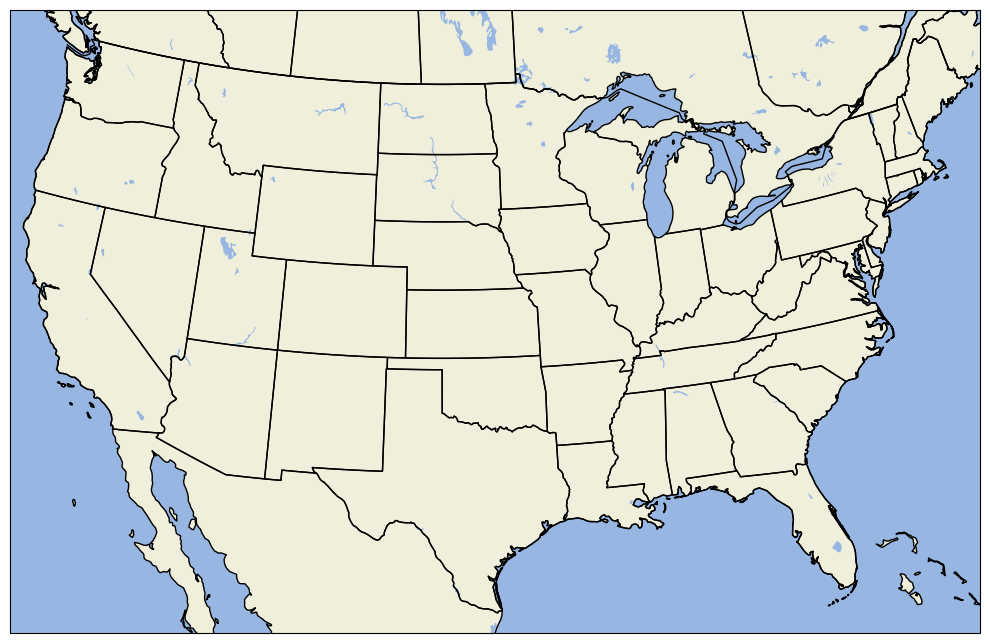

In [77]:
#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#save the map as empty_map.png
'''plt.savefig('emptymap.png')'''

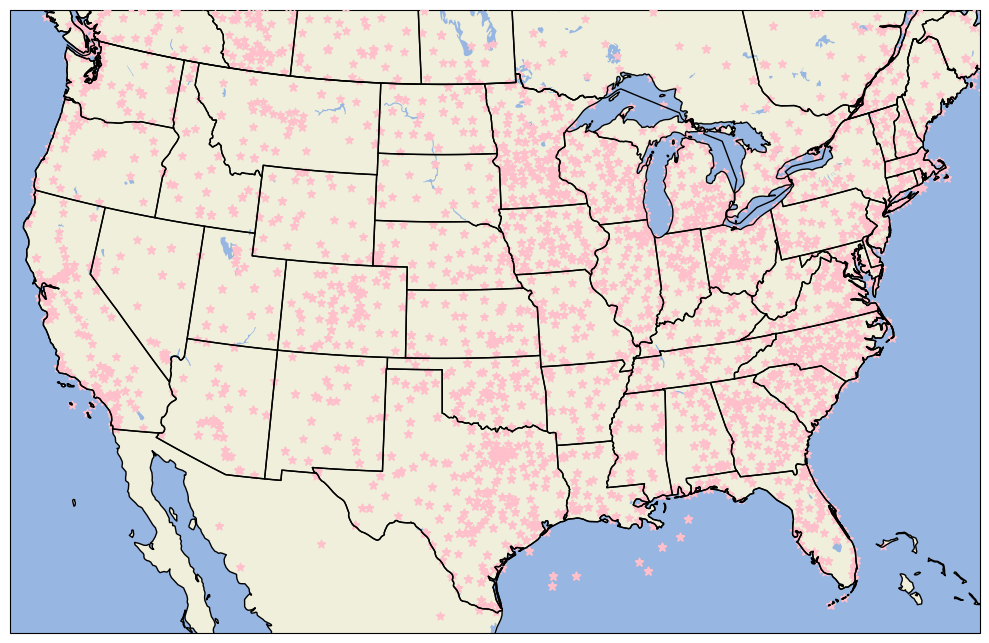

In [68]:
#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#plot surface obs using scatter plot
ax.scatter(data.longitude,data.latitude,transform=ccrs.PlateCarree(), color = 'pink', marker = '*',zorder=9)

fig.tight_layout()
#save the map as obs_locations.png
plt.savefig('obs_locations.png',bbox_inches='tight')

In [69]:
#first convert the lat/lon to map projection coordinates
locs = proj.transform_points(ccrs.PlateCarree(),data['longitude'].values,data['latitude'].values)

#now thin the data
data_thinned = data[mpcalc.reduce_point_density(locs,190*units('km'))]

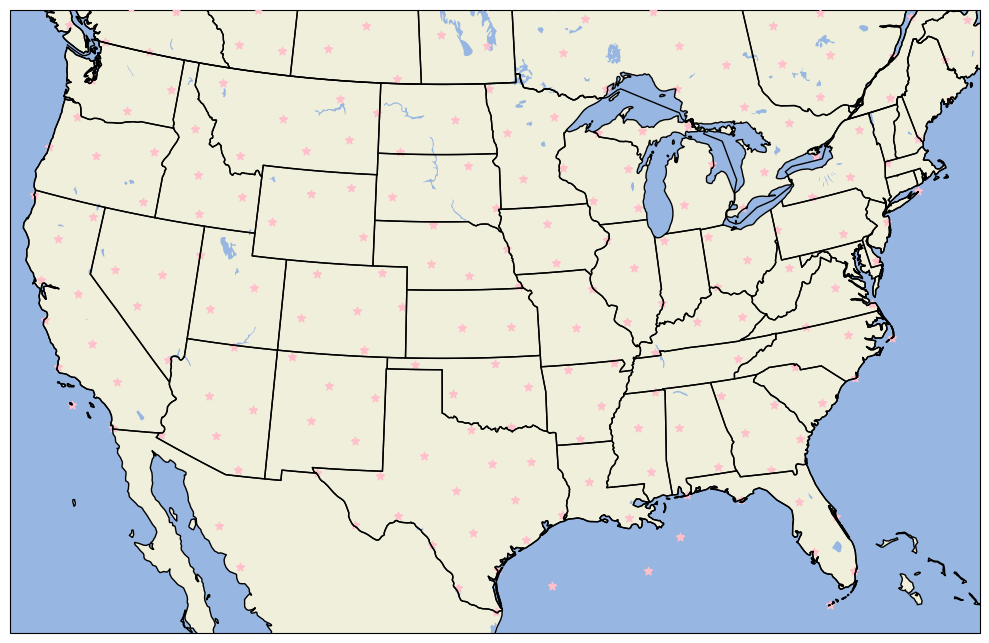

In [70]:
#save the map as obs_locations_thinned.png
#first convert the lat/lon to map projection coordinates

#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#plot surface obs using scatter plot
ax.scatter(data_thinned.longitude,data_thinned.latitude,transform=ccrs.PlateCarree(), color = 'pink', marker = '*',zorder=9)

fig.tight_layout()
#save the map as obs_locations.png
plt.savefig('obs_locations.png',bbox_inches='tight')



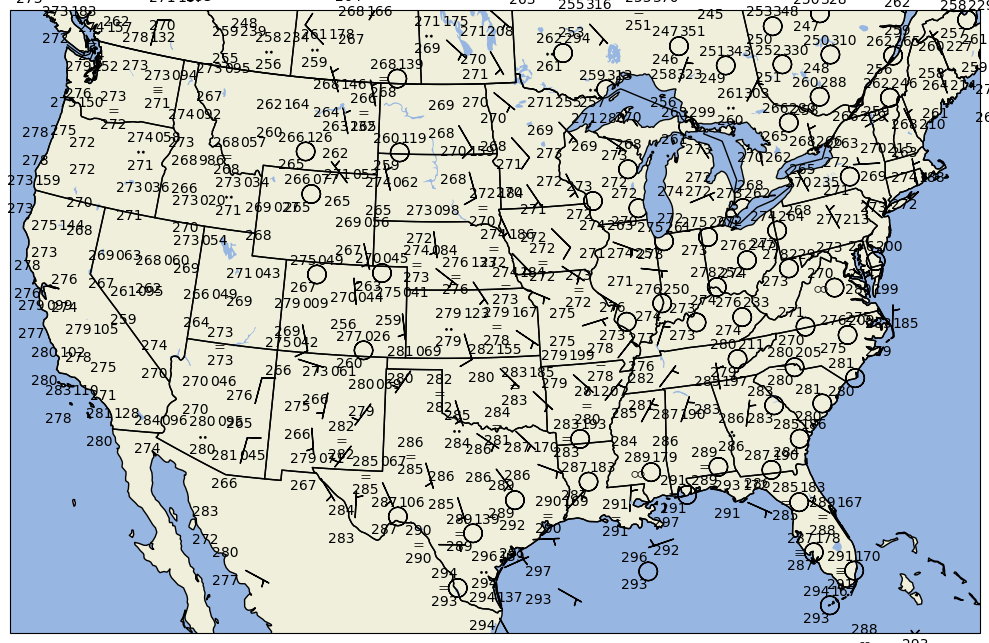

In [71]:
#save the map as obs_locations_thinned.png
#first convert the lat/lon to map projection coordinates

#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

ax.set_extent((-120, -75, 23, 50))

stationplots = StationPlot(ax, data_thinned['longitude'], data_thinned['latitude'], transform = ccrs.PlateCarree(),)
simple_layout.plot(stationplots,data_thinned)

fig.tight_layout() 

#save the map as simple_surface_obs.png
plt.savefig('simple_surface_obs.png')

In [61]:
data_thinned = data[mpcalc.reduce_point_density(locs,90*units('km'))]

In [84]:
#create wind gust vectors
u = data_thinned.eastward_wind.values * units('knots')
v = data_thinned.northward_wind.values * units('knots')
gust = data_thinned.wind_gust.values * units('knots')
wdir = mpcalc.wind_direction(u,v)

ug, vg = mpcalc.wind_components(gust,wdir)
#mpcalc.wind_direction(data_thinned).eastward_wind,data_thinned.northward_wind))
#do this by multiplying each component by the ratio of gust to speed
'''for i in ug:
    print(i)'''

temp

[271.1499938964844 265.1499938964844 280.1499938964844 ...
 262.1499938964844 278.6499938964844 260.1499938964844]


/home/kellie.thrower/miniconda3/envs/atsc270/lib/python3.11/site-packages/cartopy/crs.py:479: RuntimeWarning: overflow encountered in square
  vector_magnitudes = (u**2 + v**2)**0.5


KeyError: 'cloud_coverage'

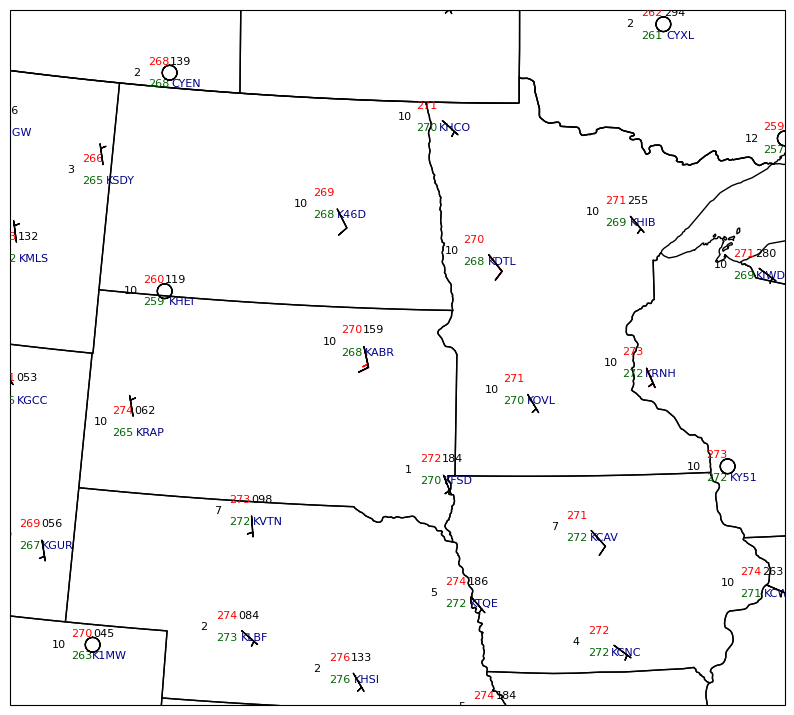

In [80]:
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the Northern Plains
ax.set_extent((-105, -90, 40, 50))

#create stationplot (will actually need to create 2 to handle wind gusts)
stationplots = StationPlot(ax, data_thinned['longitude'], data_thinned['latitude'], transform = ccrs.PlateCarree(),clip_on='True',fontsize=8)
stationplots_barbs = StationPlot(ax, data_thinned['longitude'], data_thinned['latitude'], transform = ccrs.PlateCarree(),clip_on='True',fontsize=8)
#simple_layout.plot(stationplots,data_thinned)
#temperature in red
stationplots.plot_parameter((-1,1), data_thinned['air_temperature'].values, color='red')
#dewpoint in dark green
stationplots.plot_parameter((-1,-1), data_thinned['dew_point_temperature'].values, color='darkgreen')
#pressure (need to format to be the final 3 digits)
stationplots.plot_parameter((1,1), data_thinned['air_pressure_at_sea_level'].values, color='black', formatter=lambda p: format(10*p, '.0f')[-3:])
#station ID in dark blue
stationplots.plot_text((1.5,-1), data_thinned['station_id'].values, color='darkblue')
#visibility in black (need to convert from meters to miles)
stationplots.plot_parameter((-3,0), data_thinned['visibility'].values*units('meters').to('miles'), color = 'black')
#wind gust in red
stationplots_barbs.plot_barb(ug, vg, color = 'r', zorder=9)
#wind in black
stationplots.plot_barb(data_thinned['eastward_wind'].values, data_thinned['northward_wind'].values, zorder=10)
#cloud cover
stationplots.plot_symbol('C', data_thinned['cloud_coverage'].values, sky_cover)
#current weather
stationplots.plot_symbol('W', data_thinned['current_wx1_symbol'].values, current_weather)
#save the map as surface_obs.png
plt.savefig('surface_obs.png')